<a href="https://colab.research.google.com/github/shelleyg-bit/canada-land-cover-classifier/blob/main/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!pip install rasterio

     |████████████████████████████████| 19.3 MB 7.7 MB/s 


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib import cm

In [5]:
import rasterio as rio
import pandas as pd
import seaborn as sns

# Data Load

In [6]:
tif_filepath = '/content/drive/MyDrive/nrcan/sentinel_nrcan.tif'
data = rio.open(tif_filepath)

In [7]:
print(data.width, data.height, data.count, data.bounds, f"\n {data.transform}", "\n", data.crs)
width = data.width
height = data.height
height*width

2500 1771 13 BoundingBox(left=-74.171447754, bottom=45.96451541520898, right=-71.7489624024375, top=47.144897486) 
 | 0.00, 0.00,-74.17|
| 0.00,-0.00, 47.14|
| 0.00, 0.00, 1.00| 
 EPSG:4326


4427500

In [8]:
data_list = []
for i in range(13):
    if i < 9:
        name = f'band{i+1:02d}'
    elif (i == 9)  | (i == 10):
        name = f'band{i+2:02d}'
    elif i == 11:
        name = f'band8a'
    elif i == 12:
        name = f'land_type'
    band_i = pd.Series(data.read(i+1).flatten(), name=name)
    data_list.append(band_i)


In [9]:
for i in range(13):
    print(data_list[i].name, data_list[i][1])

band01 0.3068
band02 0.2572
band03 0.2449
band04 0.2263
band05 0.2482
band06 0.2813
band07 0.2894
band08 0.2943
band09 0.3833
band11 0.2308
band12 0.1814
band8a 0.2921
land_type 6.0


In [10]:
df_raw = pd.concat(data_list, axis=1, keys=[s.name for s in data_list])

In [11]:
df_raw.head()

,band01,band02,band03,band04,band05,band06,band07,band08,band09,band11,band12,band8a,land_type
0,0.2226,0.2033,0.2095,0.1944,0.2104,0.2375,0.2358,0.2584,0.3188,0.1967,0.1273,0.2301,1.0
1,0.3068,0.2572,0.2449,0.2263,0.2482,0.2813,0.2894,0.2943,0.3833,0.2308,0.1814,0.2921,6.0
2,0.3851,0.3290,0.3116,0.3010,0.3312,0.3579,0.3695,0.3420,0.4621,0.2969,0.2354,0.3778,6.0
3,0.4392,0.4069,0.3865,0.3774,0.4114,0.4332,0.4422,0.4113,0.5130,0.3676,0.3126,0.4477,1.0
4,0.4378,0.4235,0.4058,0.3930,0.4168,0.4282,0.4254,0.4364,0.5176,0.3687,0.2783,0.4234,1.0


In [52]:
df_raw = df_raw.astype({'land_type': np.uint8})
df_raw.land_type.value_counts()


6     1535146
5     1131918
15     803409
1      347161
18     338687
17     151530
8       40241
14      36066
16      26417
10      16925
Name: land_type, dtype: int64

# ML Classifier

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

## Data prep

In [117]:
SAMPLE_SIZE = df_raw.shape[0] 
df = df_raw[0:SAMPLE_SIZE]

### Resample by balancing out the classes

In [118]:
labels = df_raw.land_type.value_counts().sort_values(ascending=False)
labels

6     1535146
5     1131918
15     803409
1      347161
18     338687
17     151530
8       40241
14      36066
16      26417
10      16925
Name: land_type, dtype: int64

In [119]:
median_label_count = labels.min()
median_label_count

16925

In [120]:
from __future__ import division

In [121]:
for label,count in labels.iteritems():
    excess = int(count - median_label_count)
    print(excess / median_label_count, label)
    if (excess  > 0.10 * median_label_count):
        remove = np.random.choice((df[(df.land_type == label)]).index, excess, replace=False)
        df.drop(remove, inplace=True)
        print(remove[0:10])

df.reset_index(inplace=True)
    

89.70286558345643 6


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[4388582  322498 1985762  640170 1890329 2343068 3948689 1055769 2111868
 1920620]
65.87846381093058 5
[1116839  882183 2223363 2322081 3126796 2820688 1189146 1402295 3707197
 3732890]
46.46877400295421 15
[1614672 2976467 2579454 3928891 2394037 3319607 3445775 4255724 3109017
 3881049]
19.5117282127031 1
[2228041  965784  760896   60376  822459   88923 1651604  937074  327476
  868335]
19.011048744460858 18
[4100398 1242807 1441121 2685894  520130 4100413 3414000 1130996  457313
 3461414]
7.953028064992615 17
[2003646 2733743 3188311 2594999  358127 1332277 4187118 4312507 1809040
 3953496]
1.3776070901033974 8
[1135398 4113748 3314864 1651794    5690 3015250  621114 2809207 3221260
 3184067]
1.130930576070901 14
[4400847 4121887 2201616 1707260 3397224 3617704 2952210 1600198 3354596
 3619682]
0.5608271787296898 16
[2931672 2021539  615353 2137853  183373  939442 2624109 1767175 2081929
 1811509]
0.0 10


In [122]:
df.index

RangeIndex(start=0, stop=169250, step=1)

In [123]:
df.land_type.value_counts().sort_values()

6     16925
8     16925
14    16925
18    16925
16    16925
10    16925
1     16925
5     16925
17    16925
15    16925
Name: land_type, dtype: int64

### Normalizing feature values

In [124]:
y = df.land_type
X = df.drop(['land_type'], axis=1)
columns = X.columns

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Training the model

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(135400, 13) (33850, 13) (135400,) (33850,)


In [126]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [134]:
clf=RandomForestClassifier(n_estimators=200, max_features='sqrt', min_samples_leaf=10, max_depth=10)
clf.fit(X_train,y_train)


RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=10,
                       n_estimators=200)

## Prediction

In [135]:
y_pred=clf.predict(X_test)

In [141]:
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_test, y_pred))

Balanced Accuracy: 0.36701513875885117


In [140]:
print("Normal Accuracy:", metrics.accuracy_score(y_test, y_pred, normalize=True))

Normal Accuracy: 0.3680354505169867


In [131]:
y_pred[0:100]

array([10, 17, 17, 18, 14, 15, 17,  1, 10, 15, 14, 17,  1,  5, 17, 10, 14,
       10, 14, 14, 14,  1,  6, 10, 17,  1, 14, 18, 18, 18, 16, 15, 10,  5,
       15, 15, 17, 15, 15,  8, 18, 15, 18,  1, 10,  5,  1,  8, 14,  6,  1,
        1, 14, 17, 18,  5,  6,  5, 16, 17, 18, 14, 14, 17, 10, 18,  1,  5,
       14, 15, 10, 15,  1,  6, 17, 17,  6, 15, 18,  5, 18,  5,  5, 10, 10,
       18, 10, 15, 14, 14,  1, 18, 15, 10, 17, 15,  1, 14, 10, 10],
      dtype=uint8)

### Confusion matrix
[What is confusion matrix?](https://machinelearningmastery.com/confusion-matrix-machine-learning/)

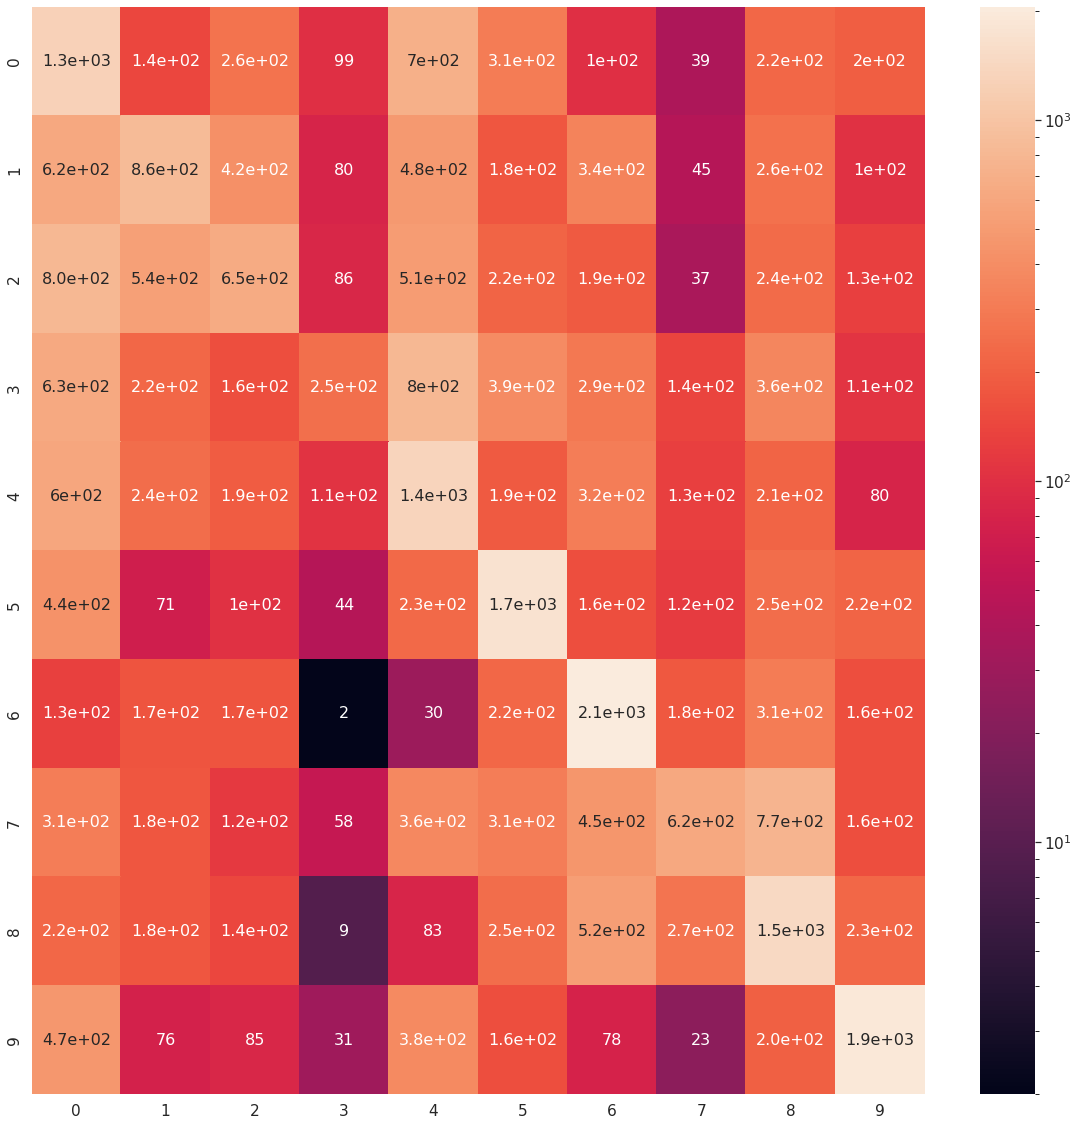

In [133]:
from matplotlib.colors import LogNorm, Normalize
results = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(results, range(10), range(10))
plt.figure(figsize=(20,20))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, norm=LogNorm()) # font size
plt.show()

## Model Interpretation

In [ ]:
pd.Series(clf.feature_importances_, index=['1', '2', '3', '4', '5', '6', '7', '8','9','11','12','8a']).sort_values(ascending=False)

12    0.104299
11    0.101436
9     0.099431
1     0.095801
8a    0.094142
8     0.085731
7     0.078586
2     0.077536
5     0.066588
6     0.066498
4     0.065195
3     0.064757
dtype: float64

# Data visualization

In [ ]:
#### Example plotting functions to display S2 data in Python

def show_band_matrix():
    fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(50,25))
    plt.suptitle("Sentinel-2 Bands", fontsize=60)
    band_count = 1
    for i,ax_row in enumerate(axes):
        for j, ax_col in enumerate(ax_row):
            if i == 0: # Multichannel bands
                title = IMG_TITLES[j]
                imband = np.asarray([np.asarray(df[BAND_NAMES[j]]).reshape( \
                         WIDTH, HEIGHT), np.asarray(df[BAND_NAMES[j]+'_1']).reshape(WIDTH, \
                         HEIGHT), np.asarray(df[BAND_NAMES[j]+'_1_2']).reshape(WIDTH, HEIGHT)]).T
            elif i == 2 and j == 3: # Special case for 8a band
                title = 'b8a'
                imband = np.asarray(df[title]).reshape(WIDTH, HEIGHT).T
                band_count += 1
            else: # Individual bands
                title = 'b' + str(band_count).zfill(2)
                imband = np.asarray(df[title]).reshape(WIDTH, HEIGHT).T
                band_count += 1
            
            axes[i][j].set_title(title)
            axes[i][j].imshow(imband, aspect='auto')
            axes[i][j].set_axis_off()

def show_land_cover():
    fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(40,15))
    ax.set_title("NRCan - 2015 Land Cover of Canada")
    cmap = cm.get_cmap('jet', 7)    # 11 discrete colors
    im = ax.imshow(np.asarray(df.land_cover).reshape(WIDTH, HEIGHT).T, cmap=cmap, aspect='auto')
    ax.set_axis_off()
    cbar = plt.colorbar(im, ax=ax)
    tick_locs = (np.arange(7) + 0.5)*(7-1)/7
    cbar.set_ticks(tick_locs)
    cbar.set_ticklabels(LAND_COVER_TYPES)
    
    ax2.grid(linestyle='--')
    dp = sns.distplot(df.land_cover, hist=False, kde_kws=dict(linewidth=8))
    ax2.set_xticks(np.arange(7))
    ax2.set_xticklabels(LAND_COVER_TYPES, fontsize=20)
    l1 = ax2.lines[0]
    x1 = l1.get_xydata()[:,0]
    y1 = l1.get_xydata()[:,1]
    ax2.fill_between(x1,y1, color="#5471ab", alpha=0.3)
    ax2.set_xlabel("Land Cover Type")
    ax2.set_title("Land Cover Density")

show_band_matrix()
show_land_cover()

